In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from siglent_sds import SDS824X_HD

In [2]:
# Connect to the oscilloscope
sds = SDS824X_HD(host="10.42.0.59")

INFO:siglent_sds.connectors.SDS_Socket_Connector:Connecting to server at 10.42.0.59:5025.
INFO:siglent_sds.base.SDS_Base:Connection established with ('10.42.0.59', 5025).


In [3]:
# Configure the experiment, start by giving the device a reset to enter a known state
sds.reset()
# We'll use C1 for an external TTL trigger, C2 and C3 for the signals of interest
sds.channels_enabled("C1 C2 C3")
# Configure timebase and memory depth
sds.timebase_scale(10e-6)
sds.acquire_memdepth("100k")
# Configure channels
sds.channel_scale(channel=1, scale=2.0, offset=0.0)
sds.channel_scale(channel=2, scale=2.0, offset=-5.0)
sds.channel_scale(channel=3, scale=2.0, offset=-5.0)
# Configure edge triggering
sds.trigger_edge(source=1, level=2.0, slope="rising")
# Configure sequence mode to take 100 waveforms
sds.sequence(100)
# The signal we're interested in is about 1.01 ms after the trigger
# We use timebase_delay instead of waveform_start due to bug when using sequence mode
sds.timebase_delay(1.01e-3)
# and the signal lasts for about 0.02 ms
sds.waveform_points(t=0.02e-3)

Data size 2×100×10000 = 2e+06 data points from t = 0.00096 to 0.000979998 s 
Memory use including time axis = 7.668 MiB
Time and data dtypes = float32, float32


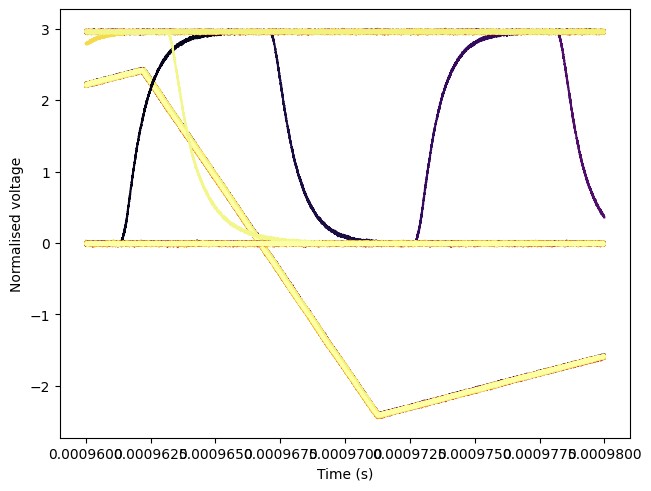

In [6]:
# Set single shot triggering to start collecting waveforms
sds.trigger_mode("single")
# Wait for them to acquire...
time.sleep(2.0)

channels, t, data = sds.get_waveforms("C2 C3")

if not data is None:
    fig, ax = plt.subplots(constrained_layout=True)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for ch_i, ch in enumerate(channels):
        colors = mpl.colormaps["inferno"](np.linspace(0, 1, data.shape[1]))
        for seq_i in range(data.shape[1]):
            ax.plot(t, data[ch_i, seq_i], color=colors[seq_i], alpha=1.0, label=f"{ch}-{seq_i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalised voltage")
    #ax.legend()
    print(f"Data size {data.shape[0]}×{data.shape[1]}×{data.shape[2]} = {data.size:g} data points from t = {t[0]:g} to {t[-1]:g} s ")
    print(f"Memory use including time axis = {(data.size*data.itemsize + t.size*t.itemsize)/2**20:0.3f} MiB")
    print(f"Time and data dtypes = {t.dtype}, {data.dtype}")
else:
    print("No new waveforms.")


In [ ]:
sds.close()